Example notebook to generate Fig. 10 (log distance ratio v. redshift) for the EDR TF paper.

In [1]:
import numpy as np

from astropy.io import fits

from scipy.stats import binned_statistic

import matplotlib.pyplot as plt

# Data

In [2]:
hdul = fits.open('fig10_data.fits')

gals = hdul[1].data

hdul.close()

In [3]:
dwarf_boolean = gals['DWARF']

# Plot

In [4]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

In [5]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

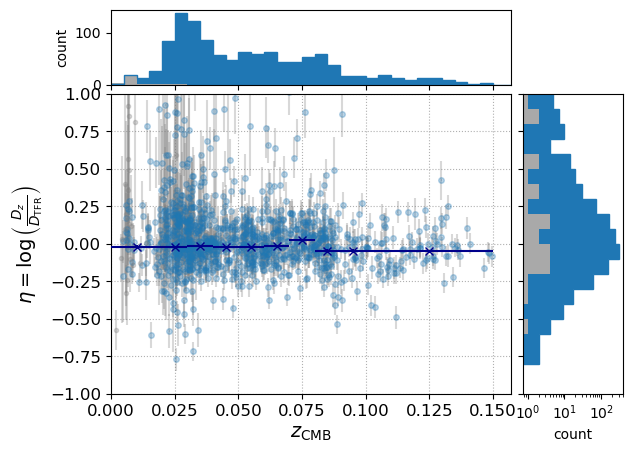

In [6]:
fig = plt.figure()

gs = fig.add_gridspec(2, 2, 
                      width_ratios=(4,1), 
                      height_ratios=(1,4), 
                      left=0.1, 
                      right=0.9, 
                      bottom=0.1, 
                      top=0.9, 
                      wspace=0.05, 
                      hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax.errorbar(gals['Z'][~dwarf_boolean], 
            gals['LOGDIST'][~dwarf_boolean], 
            xerr=gals['Z_ERR'][~dwarf_boolean], 
            yerr=gals['LOGDIST_ERR'][~dwarf_boolean],
            fmt='o', 
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')
ax.errorbar(gals['Z'][dwarf_boolean], 
            gals['LOGDIST'][dwarf_boolean], 
            xerr=gals['Z_ERR'][dwarf_boolean], 
            yerr=gals['LOGDIST_ERR'][dwarf_boolean],
            fmt='.', 
            color='gray',
            alpha=0.3, 
            ecolor='gray')


N, y_avg, y_std = profile_histogram(gals['Z'][~dwarf_boolean], 
                                    gals['LOGDIST'][~dwarf_boolean], 
                                    zbins, 
                                    yerr=gals['LOGDIST_ERR'][~dwarf_boolean],
                                    weighted=True
                                   )
ax.errorbar(zc[:-1], y_avg[:-1], xerr=dz[:-1], yerr=y_std[:-1], fmt='x', color='darkblue', zorder=3)

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

ax.set_ylim((-1, 1))

ax.set_xlim((0, 0.157))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(gals['Z'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(gals['Z'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray')
ax_histx.hist(gals['Z'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='tab:blue', histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)

ax_histx.set_ylabel('count', fontsize=10)


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(gals['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal')
ax_histy.hist(gals['LOGDIST'][dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(gals['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)

ax_histy.set_xlabel('count', fontsize=10);